# Overview

In [1]:
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
random_state = 42

## Datensatz laden

Quelle: [https://www.kaggle.com/c/porto-seguro-safe-driver-prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction)

In [2]:
df = pd.read_csv('../datasets/safe-driver-prediction.csv')

## Informationen zum Datensatz

* Features that belong to **similar groupings are tagged** as such in the feature names (e.g., ind, reg, car, calc).
* Feature names include the postfix **bin** to indicate binary features and **cat** to indicate categorical features.
* Features **without these designations are either continuous or ordinal**.
* Values of **-1** indicate that the feature was **missing** from the observation.
* The **target** columns signifies whether or not a claim was filed for that policy holder.

# Übersicht

In [3]:
df.head(n=5)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


## Größe des Datensatzes

In [4]:
df.shape

(595212, 59)

## Metadaten extrahieren

* **role**: input, ID, target
* **level**: nominal, interval, ordinal, binary
* **keep**: True or False
* **dtype**: int, float, str

In [5]:
data = []
for column in df.columns:
    # Defining the role
    if column == 'target':
        role = 'target'
    elif column == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in column or column == 'target':
        level = 'binary'
    elif 'cat' in column or column == 'id':
        level = 'nominal'
    elif df[column].dtype == np.dtype('float64'):
        level = 'interval'
    elif df[column].dtype == np.dtype('int64'):
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if column == 'id':
        keep = False
    
    # Defining the data type 
    dtype = df[column].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    column_dict = {
        'column_name': column,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(column_dict)
    
df_meta = pd.DataFrame(data, columns=['column_name', 'role', 'level', 'keep', 'dtype'])
df_meta.set_index('column_name', inplace=True)

## Anzahl der Attribute pro Rolle und Level

In [6]:
pd.DataFrame({'count' : df_meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


## Beschreibende Statistik zum Datensatz

### Intervall-Attribute

In [7]:
query = df_meta[(df_meta.level == 'interval') & (df_meta.keep)].index
df[query].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


* "reg"-Attribute
 * ps_reg_03 zeigt fehlende Werte
 * (min/max) ist unterschiedlich in der Gruppe

* "car"-Attribute
 * ps_car_12 & ps_car_15 zeigen fehlende Werte
 * (min/max) ist unterschiedlich in der Gruppe

* "calc"-Attribute
 * keine fehlenden Werte
 * Könnte eine Art Verhältnis zu sein, da das Maximum bei 0,9 liegt
 * Alle drei Attribute haben sehr ähnliche Verteilungen


### Ordinale-Attribute

In [8]:
query = df_meta[(df_meta.level == 'ordinal') & (df_meta.keep)].index
df[query].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


* "ind"-Attribute
 * keine fehlenden Werte
 * (min/max) ist unterschiedlich in der Gruppe
 
* "car"-Attribute
 * ps_car_11 zeigt fehlende Werte
 
* "calc"-Attribute
 * keine fehlenden Werte
 * (min/max) ist unterschiedlich in der Gruppe

### Binäre-Attribute

In [9]:
query = df_meta[(df_meta.level == 'binary') & (df_meta.keep)].index
df[query].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* "target"-Attribute
 * Klasse ist "imbalanced"
 
Aus dem Wert "mean" können wir schließen, dass für die meisten Attribute der Wert in den meisten Fällen Null ist.

# Visualisierung

## Allgemein

### Fehlende Werte

In [10]:
df_tmp = df.replace(to_replace=-1, value=np.NaN)
df_tmp[df_tmp.columns[df_tmp.isnull().any()]].isnull().sum()

ps_ind_02_cat       216
ps_ind_04_cat        83
ps_ind_05_cat      5809
ps_reg_03        107772
ps_car_01_cat       107
ps_car_02_cat         5
ps_car_03_cat    411231
ps_car_05_cat    266551
ps_car_07_cat     11489
ps_car_09_cat       569
ps_car_11             5
ps_car_12             1
ps_car_14         42620
dtype: int64

### Verteilung der Klassen

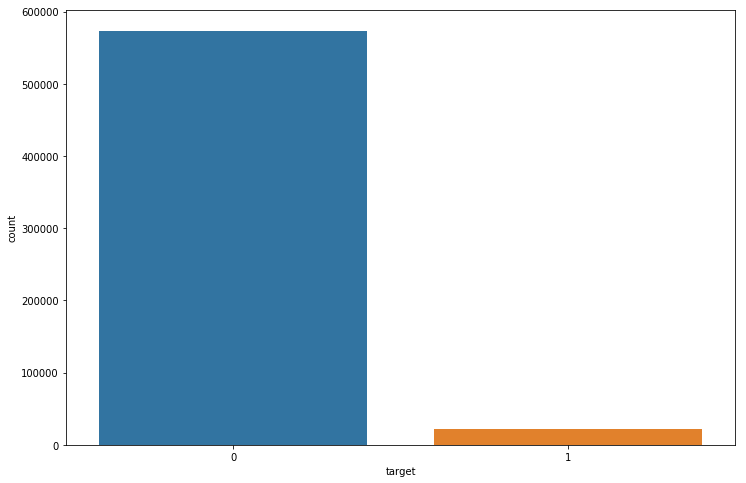

In [11]:
plt.figure(figsize=(12, 8))
sns.countplot(x='target', data=df);

# Korrelation zwischen Attributen

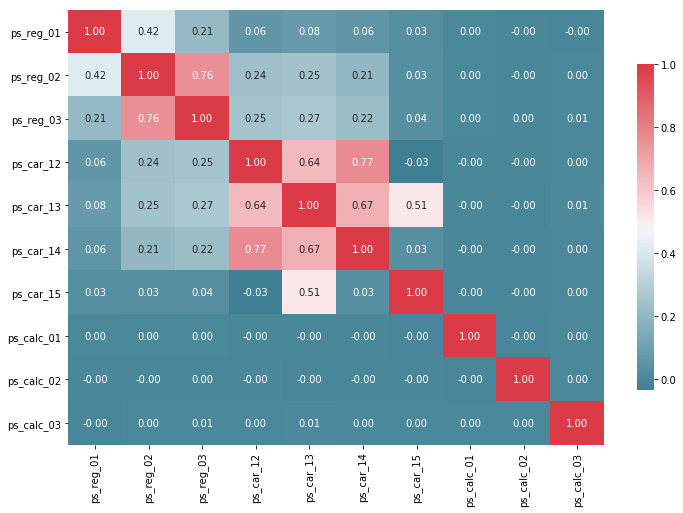

In [12]:
df_corr = df.replace(to_replace=-1, value=np.NaN)
df_corr.dropna(axis=0, inplace=True)

query = df_meta[(df_meta.level == 'interval') & (df_meta.keep)].index

plt.figure(figsize=(12, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr[query].corr(), cmap=cmap, fmt='.2f', annot=True, cbar_kws={'shrink': .75});

## Beziehung zwischen einzelnen Attributen

In [13]:
df_sample = df.replace(to_replace=-1, value=np.NaN)
df_sample.dropna(axis=0, inplace=True)
df_sample = df_sample.sample(frac=0.1)

### ps_reg_02 & ps_reg_03

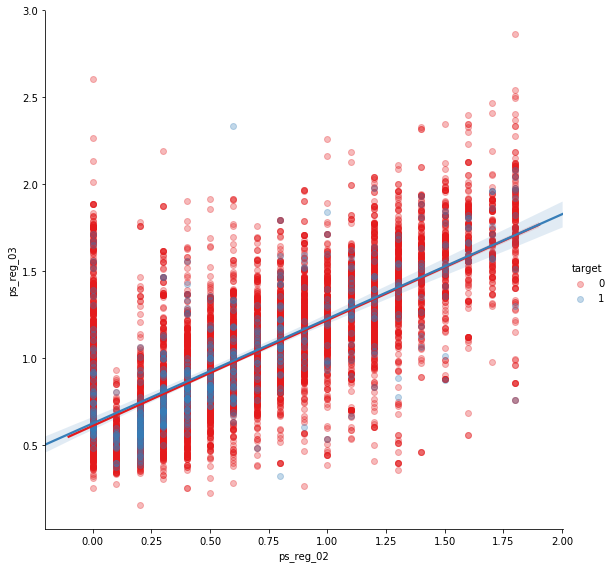

In [14]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=df_sample, hue='target', palette='Set1', scatter_kws={'alpha':0.3}, size=8);

### ps_car_12 & ps_car_13

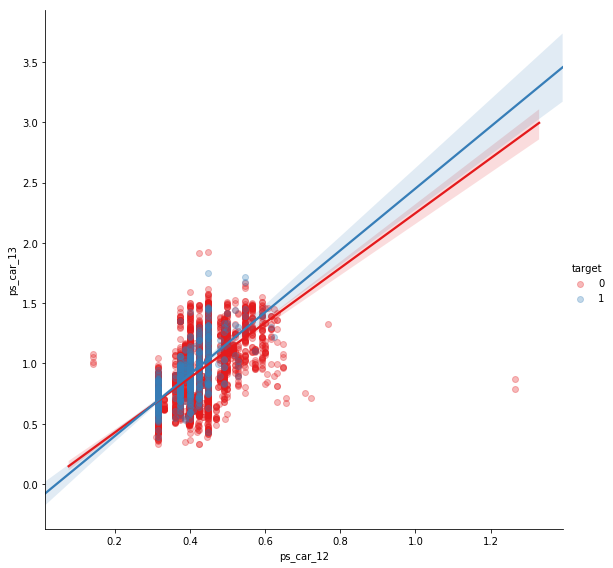

In [15]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=df_sample, hue='target', palette='Set1', scatter_kws={'alpha':0.3}, size=8);

### ps_car_12 & ps_car_14

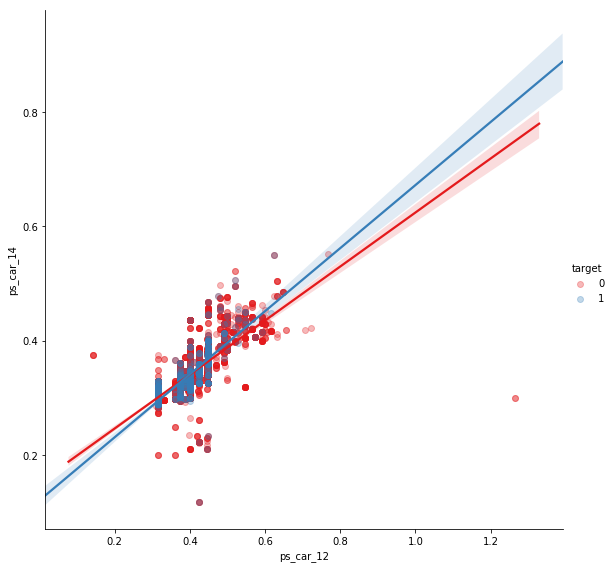

In [16]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=df_sample, hue='target', palette='Set1', scatter_kws={'alpha':0.3}, size=8);

### ps_car_13 & ps_car_14

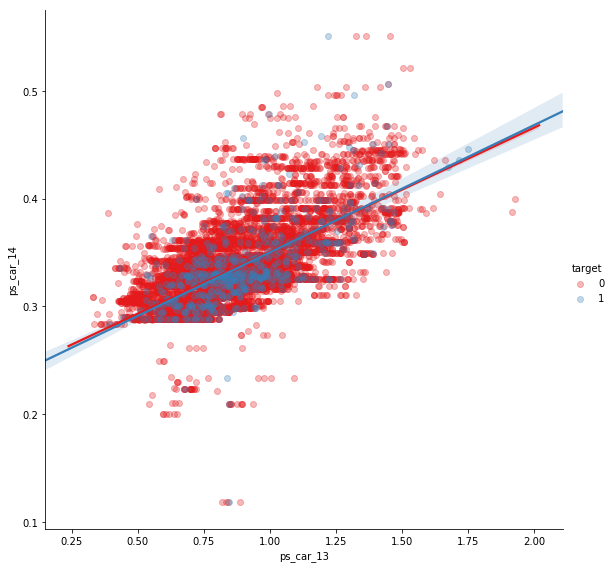

In [17]:
sns.lmplot(x='ps_car_13', y='ps_car_14', data=df_sample, hue='target', palette='Set1', scatter_kws={'alpha':0.3}, size=8);